# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 8

**Issued**: Tuesday, June 18, 2024, 1:00 pm

**Due**: Tuesday, June 25, 2024, 1:00 pm

# MRI reconstruction with diffusion models

In this homework, we consider reconstructing (complex) images from undersampled MRI measurements with a diffusion model. There are various approaches, such as the posterior sampling based methods discussed in the lecture, but we will focus on the *variational approach* to reconstruction in this homework.

**MRI**: Given an unknown $\mathbf{x}$ object (knee for example), the MRI device provides complex measurements $\mathbf{y} \in \mathbb{C}^m$, which are given as:
$$
\mathbf{y} = \mathbf{M} \mathbf{F} \mathbf{x} + \mathbf{z},
$$
where $\mathbf{M}$ is an under-sampling mask, which models an acceleration of the MRI acquisition. The elements of $\mathbf{M}$ are $1$ if a measurement is taken at that location (in measurement space) and $0$ otherwise. Moreover, $\mathbf{F}$ is the two-dimensional discrete Fourier transformation, and $\mathbf{z}$ additive noise. Note, that this is a simplified description of MRI, since in practice there are multiple measurements $\mathbf{y}_i$ taken in parallel.

**Diffusion model**: You will perform reconstruction with a diffusion model $\epsilon_{\theta}(\mathbf{x}_t, t)$, where $t$ is a timestep in the diffusion process and $\mathbf{x}_t$ a corresponding noisy sample of the forward process. The diffusion provided to you is pre-trained on complex MRI knee images, by minimizing the diffusion model training objective:
$$
L(\theta) = \mathbb{E}_{\mathbf{x}, t \sim \mathcal{U}(0, 1000), \epsilon \sim \mathcal{N}(0, \mathbf{I})} [ \| \epsilon_{\theta}(\mathbf{x}_t, t) - \epsilon \|^2]
$$
where $\mathbf{x}_t = \sqrt{1 - \sigma_t^2} \mathbf{x} + \sigma_t \epsilon$. Here, the DDPM parametrization is used, with $\sigma_t^2$ as defined in the lecture.

**Task preview**: The homework consists of two tasks (detailed below).
 1. Visualize the forward diffusion process (for DDPM parametrization)
 2. Implement the variational loss for reconstruction images from an undersampled MRI measurement

# Introduction

In [1]:
# on colab (and locally) you might need to install fastmri library
# !pip install fastmri

In [2]:
import torch
from tqdm import tqdm
import fastmri.data
import fastmri.data.subsample
import fastmri.data.transforms as fdt
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import Tuple

In [3]:
device = "cuda:0"
data_sample_path = "data_sample.pt"
model_path = "model.pt"

use_colab = False
if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  # base_folder might need to be adapted
  base_folder = '/content/drive/MyDrive/hw8'
  data_sample_path = f'{base_folder}/{data_sample_path}'
  model_path = f'{base_folder}/{model_path}'

  # import base folder, so that we can use the unet python module
  import sys
  sys.path.append(f"{base_folder}")
# else assume that the files are locally available

## MRI inverse problem

In [4]:
# we choose an acceleration and a fixed mask_seed
acceleration = 4.0
mask_seed = 3

# we choose a random mask function, there are also other functions available
rnd_mask_func = fastmri.data.subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[acceleration], seed=mask_seed)

# forward transformation
def mri_trafo_fwd(x : torch.Tensor, mask_func = None):
    if mask_func is None:
        return fastmri.fft2c(x)
    else:
        mask, _ = mask_func(x.shape, seed=mask_seed)
        return fastmri.fft2c(x) * mask.to(device) + 0.0

# adjoint transformation
def mri_trafo_adjoint(y : torch.Tensor):
    return fastmri.ifft2c(y)

### Utils for visualization and evaluation

In [5]:
# Since our MRI sample has low contrast, we increase the contrast when visualizing the results
def normalize_clamp(im, sigma_clamp=3):
    im = (im-im.mean()) / im.std()
    return im.clamp(-sigma_clamp,sigma_clamp)

# We evaluate the reconstruction quality in terms of (complex) PSNR
def psnr(rec, target):
    mse = (rec  - target).square().mean()
    data_range = torch.max(target) - torch.min(target)
    return 20*torch.log10(data_range) - 10*torch.log10(mse)

## Load and visualize data sample

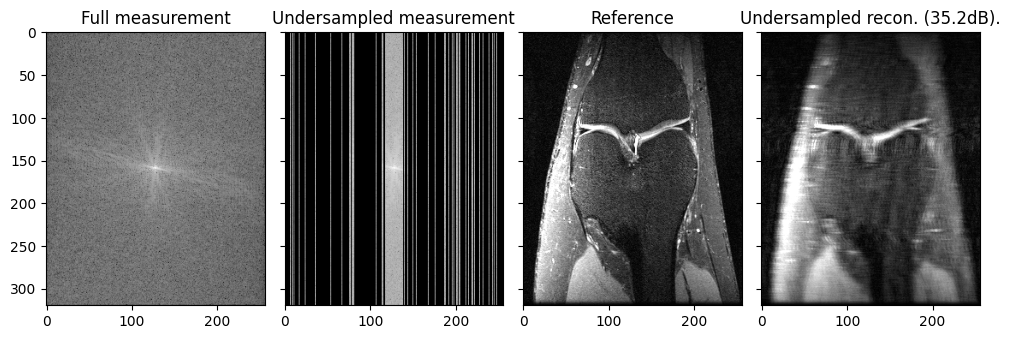

In [6]:
# the data files contain the fully-sampled kspaces
kspace = torch.load(data_sample_path).to(device).unsqueeze(dim=0)
# we obtain the complex target / reference image from the ifft
complex_target = fastmri.ifft2c(kspace)

# we simulate an undersampled measurement by applying the forward trafo (with the random mask func)
masked_kspace = mri_trafo_fwd(complex_target, rnd_mask_func)

# a simple reconstruction can be obtained by the adjoint trafo
pseudorec = mri_trafo_adjoint(masked_kspace)

# as first row, we plot the kspace (in logarithmic scale)
fig, ax = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(10, 4*10))
ax[0].imshow(  (kspace.squeeze(0).norm(dim=-1) + 1e-9).log().cpu(), cmap='gray')
ax[0].set_title("Full measurement")
ax[1].imshow(  (masked_kspace.squeeze(0).norm(dim=-1) + 1e-9).log().cpu(), cmap='gray')
ax[1].set_title("Undersampled measurement")

# and the magnitude of the reference / pseudoinverse reconstruction
ax[2].set_title("Reference")
ax[2].imshow(normalize_clamp(complex_target.norm(dim=-1).squeeze().cpu()), cmap="gray")
ax[3].set_title(f"Undersampled recon. ({psnr(pseudorec, complex_target):.1f}dB).")
ax[3].imshow(normalize_clamp(fastmri.complex_abs(pseudorec).squeeze(0).cpu()), cmap="gray")

fig.tight_layout()

## Loading the diffusion model

The U-Net architecture used in this homework is more complex than the U-Net models from the previous homeworks. Despite additional transformer layers, and other details, the diffusion model takes into account the provided time-steps in the diffusion process.

In [7]:
from diffmodels.unet import UNetModel
base_config = {
    "num_heads": 4,                       # nr of attention heads
    "num_res_blocks": 4,                  # nr of residual blocks per stage
    "attention_resolutions": [],          # resolution at which we have attention (only bottleneck)
    "use_scale_shift_norm": True,         # type of timestep conditioning
    "resblock_updown": True,              # we use AvgPooling and nearest neighbor interpolation for up/downsampling
    "channel_mult" : tuple([1, 2, 2, 2]), # channel multiplier per stage
    "in_channels" : 2,                    # two channels (since we our images have real and imaginary parts)
    "out_channels" : 2,                   # see above
    "model_channels" : 32                 # nr of channels in the first layer
}
diff_unet = UNetModel(**base_config)
diff_unet.load_state_dict(torch.load(model_path, map_location=device))
diff_unet = diff_unet.to(device)

# Task 1: Diffusion model forward process

As preparation for the reconstruction method, we need to work out the diffusion model's forward process. For this homework, we consider the DDPM parametrization with the $\beta_i$'s increasing linearly from $\beta_{min}=0.0001$ to $\beta_{max}=0.02$ with $T = 1000$ steps.

**Task**: Implement the diffusion model forward process $q(\mathbf{x}_t | \mathbf{x}_0)$ and visualize the forward process.

In [8]:
# Draws a Gaussian noise sample z~N(0,I) and yields a (noisy) sample from q(x_t | x_0).
# Shall return both x_t and z (used later)
def diffusion_ddpm_forward(x0 : torch.Tensor, t : torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    z = torch.randn_like(x0)
    beta = np.linspace(0.0001,0.02,1000,endpoint=True)
    for i in range(int(t)):
        z = torch.randn_like(x0)
        b = beta[i]
        x0 = np.sqrt(1-b)*x0 + np.sqrt(b)*z
    return x0, z
    # raise NotImplementedError("Implement the forward process q(x_t | x_0) for a given timestep t!")

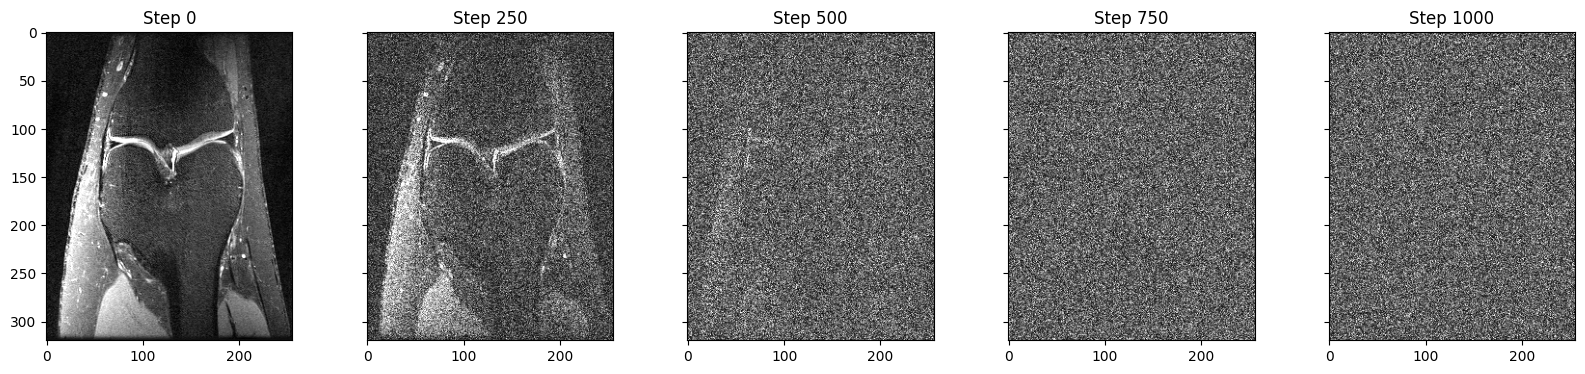

In [9]:
# visualization
nr_samples = 5
# the diffusion model is trained on normalized data
x0 = (complex_target - complex_target.mean()) / complex_target.std()
fig, ax = plt.subplots(ncols=nr_samples, sharey=True, figsize=(nr_samples*4, 4))
for i in range(nr_samples):
    timestep = (1000 // (nr_samples - 1)) * i
    x = diffusion_ddpm_forward(x0, timestep)[0]
    ax[i].imshow(normalize_clamp(fastmri.complex_abs(x).squeeze(0).cpu()), cmap="gray")
    ax[i].set_title(f"Step {timestep}")

# Task 2: MRI reconstruction with diffusion models

In the following, you see the method used for reconstruction. We approach the reconstruction as an optimization problem, where the objective function `var_loss` is minmized with respect to the unknown image $\mathbf{x}$. We employ gradient descent (Adam), and scale our measurements (and data) such that our reconstruction has approximately zero mean and unit variance (similar to the normalization used in end-to-end learning). Your task is to implement the reconstruction objective `var_loss`.

In [10]:
# minimizes the var_loss objective using gradient descent
def perform_reconstruction(var_loss, measurement, complex_target, lr = 0.1, iterations = 200, seed=0, random_init=False):
    # set seed for reproducibility
    torch.manual_seed(seed) # set the seed for experiment reproducibility

    # we scale the observation so that we can use standard learning rates
    scaling_factor = 2*math.sqrt(float(np.prod(measurement.shape).item())) / measurement.detach().cpu().norm()

    # we use the (scaled) pseudoinverse to initialize reconstruction (but can also start from random)
    x0_scaled = fastmri.ifft2c(measurement * scaling_factor)

    # we initialize the reconstruction from random (or from the pseudoinverse which is faster)
    if random_init:
        xinit = torch.randn_like(x0_scaled)
    else:
        xinit = x0_scaled.clone()

    # we use a torch parameter and Adam optimizer
    rec = torch.nn.Parameter(xinit, requires_grad=True)
    optimizer = torch.optim.Adam([rec], lr=lr)

    # perform gradient descent to minimize the var_loss objective
    with tqdm(range(iterations), desc='reconstructing') as pbar:
        for _ in pbar:
            optimizer.zero_grad()
            # here we calculate the loss wrt to the objective function you implement
            loss = var_loss(rec, measurement * scaling_factor)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'psnr': psnr(rec / scaling_factor, complex_target).item(), 'loss': loss.item()})
    return rec / scaling_factor

# a helper function to visually compare the results
def plot_reconstruction(rec, complex_target):
    fig, ax = plt.subplots(ncols=3, figsize=(10, 30), sharey=True)
    ax[0].imshow(normalize_clamp(complex_target.norm(dim=-1).squeeze().cpu()), cmap="gray")
    ax[0].set_title("Reference slice")
    ax[1].imshow(normalize_clamp(pseudorec.cpu().squeeze().norm(dim=-1)), cmap="gray")
    ax[1].set_title(f"Pseudoinverse rec {psnr(pseudorec, complex_target).item():.1f}dB")
    ax[2].imshow(normalize_clamp(fastmri.complex_abs(rec).detach().cpu().squeeze(0)), cmap="gray")
    ax[2].set_title(f"Reconstruction {psnr(rec, complex_target).item():.1f}dB")
    fig.tight_layout()

**Task**: Implement the `variational_loss` as described in the lecture notes, and given by the following equation:
$$
    L(\mathbf{x}) = \| \mathbf{A} \mathbf{x} - \mathbf{y} \|^2 + \mathbb{E}_{t, \mathbf{\epsilon}} [ \lambda w(t) \| \epsilon_{\theta}(\mathbf{x}_t, t) - \mathbf{\epsilon} \|^2],
$$
where $\mathbf{A}$ refers to the forward map of the inverse problem, $\mathbf{y}$ is the (undersampled) measurement, and $\epsilon_{\theta}(\mathbf{z}, t)$ the pre-trained diffusion model. Note, that we rescaled the objective compared to the lecture notes, since we do not know the variance $\sigma^2$.


**Note**:
- The diffusion model treats the *complex channels* (real and imaginary part) as two color channels, so you may need to swap the axes before applying the score model.
- Reuse the diffusion model forward process implemented in task 1, for obtaining the noisy samples
- Experiment with different *weighting functions* $w(t)$, you should obtain improved results compared to the PSNR of the pseudoinverse (for $\lambda = 5e-7$).


In [29]:
# Implementation of the variational objective
# --------------------------------------------------------------
# It should depend on:
# - The parameters of the function (unknown x, undersampled measurement)
# - A regularization parameter `reg_strength` (the value $\lambda = 5e-7$ works well), but you can experiment with other setttings as well
# - The diffusion U-Net model and the DDPM forward process definition (implemented in task 1)
# - The forward transformation `mri_trafo_fwd` of the MRI problem, with the correct masking function (you can also use the adjoint)
def variational_loss(x, measurement):
    import torch
    from torch.nn import functional as F
    # Define regularization strength
    reg_strength = 5e-7
    wt = 0.02
    
    # Forward model of the reconstructed image
    fwd_model = mri_trafo_fwd(x, rnd_mask_func)
    # Data fidelity term: Mean Squared Error between the forward model and the actual measurement
    data_fidelity = F.mse_loss(fwd_model, measurement)
    # Regularization term: Total Variation regularization
    regularization = 0
    x = torch.permute(x, (0, 3, 1, 2))
    # Compute the regularization term for different timesteps
    # I used 4 time steps to estimate the expectation
    for t in range(250,1000,250):
        x, z = diffusion_ddpm_forward(x, t)
        tensor_t = torch.tensor([t]).to(device)
        regularization += wt * F.mse_loss(diff_unet(x, tensor_t), z)
    # Total loss is a weighted sum of the data fidelity term and the regularization term
    total_loss = torch.Tensor(data_fidelity + reg_strength * regularization)
    print(type(total_loss))
    return total_loss
    raise NotImplementedError("Implement the variational loss here!")

### Reconstruction

In [30]:
# perform reconstruction using your variational loss
rec = perform_reconstruction(variational_loss, measurement=masked_kspace, complex_target=complex_target, lr=0.1, iterations=500, seed=0)
plot_reconstruction(rec, complex_target)

reconstructing:   0%|          | 0/500 [00:00<?, ?it/s]

<class 'torch.Tensor'>


reconstructing:   0%|          | 1/500 [00:34<4:43:57, 34.14s/it, psnr=35.2, loss=5.26e-8]

<class 'torch.Tensor'>


reconstructing:   0%|          | 2/500 [00:53<3:31:35, 25.49s/it, psnr=35.2, loss=6.58e-8]

<class 'torch.Tensor'>


reconstructing:   1%|          | 3/500 [01:11<3:02:47, 22.07s/it, psnr=35.2, loss=3.73e-5]

<class 'torch.Tensor'>


reconstructing:   1%|          | 4/500 [01:29<2:48:18, 20.36s/it, psnr=35.2, loss=0.00138]

<class 'torch.Tensor'>


reconstructing:   1%|          | 5/500 [01:47<2:40:27, 19.45s/it, psnr=35.2, loss=0.000197]

<class 'torch.Tensor'>


reconstructing:   1%|          | 6/500 [02:04<2:35:35, 18.90s/it, psnr=35.2, loss=0.00107] 

<class 'torch.Tensor'>


reconstructing:   1%|▏         | 7/500 [02:22<2:32:15, 18.53s/it, psnr=35.2, loss=0.000593]

<class 'torch.Tensor'>


reconstructing:   2%|▏         | 8/500 [02:40<2:30:02, 18.30s/it, psnr=35.2, loss=0.000129]

<class 'torch.Tensor'>


reconstructing:   2%|▏         | 9/500 [02:58<2:27:37, 18.04s/it, psnr=35.2, loss=0.000466]

<class 'torch.Tensor'>


reconstructing:   2%|▏         | 10/500 [03:15<2:25:50, 17.86s/it, psnr=35.2, loss=0.000584]

<class 'torch.Tensor'>


reconstructing:   2%|▏         | 11/500 [03:32<2:24:24, 17.72s/it, psnr=35.2, loss=0.000241]

<class 'torch.Tensor'>


reconstructing:   2%|▏         | 12/500 [03:50<2:23:27, 17.64s/it, psnr=35.2, loss=0.000104]

<class 'torch.Tensor'>


reconstructing:   3%|▎         | 13/500 [04:07<2:22:41, 17.58s/it, psnr=35.2, loss=0.000298]

<class 'torch.Tensor'>


reconstructing:   3%|▎         | 14/500 [04:25<2:21:57, 17.53s/it, psnr=35.2, loss=0.000359]

<class 'torch.Tensor'>


reconstructing:   3%|▎         | 15/500 [04:43<2:23:28, 17.75s/it, psnr=35.2, loss=0.000173]

<class 'torch.Tensor'>


reconstructing:   3%|▎         | 16/500 [05:00<2:22:26, 17.66s/it, psnr=35.2, loss=6.62e-5] 

<class 'torch.Tensor'>


reconstructing:   3%|▎         | 17/500 [05:18<2:21:32, 17.58s/it, psnr=35.2, loss=0.000163]

<class 'torch.Tensor'>


reconstructing:   4%|▎         | 18/500 [05:35<2:20:53, 17.54s/it, psnr=35.2, loss=0.000233]

<class 'torch.Tensor'>


reconstructing:   4%|▍         | 19/500 [05:53<2:20:23, 17.51s/it, psnr=35.2, loss=0.000142]

<class 'torch.Tensor'>


reconstructing:   4%|▍         | 20/500 [06:10<2:19:55, 17.49s/it, psnr=35.2, loss=4.78e-5] 

<class 'torch.Tensor'>


reconstructing:   4%|▍         | 21/500 [06:28<2:19:25, 17.46s/it, psnr=35.2, loss=8.26e-5]

<class 'torch.Tensor'>


reconstructing:   4%|▍         | 22/500 [06:45<2:19:05, 17.46s/it, psnr=35.2, loss=0.000146]

<class 'torch.Tensor'>


reconstructing:   5%|▍         | 23/500 [07:02<2:18:39, 17.44s/it, psnr=35.2, loss=0.000113]

<class 'torch.Tensor'>


reconstructing:   5%|▍         | 24/500 [07:20<2:18:19, 17.44s/it, psnr=35.2, loss=4.11e-5] 

<class 'torch.Tensor'>


reconstructing:   5%|▌         | 25/500 [07:37<2:18:07, 17.45s/it, psnr=35.2, loss=4.14e-5]

<class 'torch.Tensor'>


reconstructing:   5%|▌         | 26/500 [07:55<2:17:50, 17.45s/it, psnr=35.2, loss=8.82e-5]

<class 'torch.Tensor'>


reconstructing:   5%|▌         | 27/500 [08:12<2:17:30, 17.44s/it, psnr=35.2, loss=8.45e-5]

<class 'torch.Tensor'>


reconstructing:   6%|▌         | 28/500 [08:30<2:17:12, 17.44s/it, psnr=35.2, loss=3.58e-5]

<class 'torch.Tensor'>


reconstructing:   6%|▌         | 29/500 [08:48<2:18:07, 17.59s/it, psnr=35.2, loss=2.25e-5]

<class 'torch.Tensor'>


reconstructing:   6%|▌         | 30/500 [09:05<2:18:03, 17.62s/it, psnr=35.2, loss=5.23e-5]

<class 'torch.Tensor'>


reconstructing:   6%|▌         | 31/500 [09:23<2:17:31, 17.59s/it, psnr=35.2, loss=5.94e-5]

<class 'torch.Tensor'>


reconstructing:   6%|▋         | 32/500 [09:40<2:16:54, 17.55s/it, psnr=35.2, loss=2.91e-5]

<class 'torch.Tensor'>


reconstructing:   7%|▋         | 33/500 [09:58<2:16:37, 17.55s/it, psnr=35.2, loss=1.38e-5]

<class 'torch.Tensor'>


reconstructing:   7%|▋         | 34/500 [10:15<2:16:19, 17.55s/it, psnr=35.2, loss=3.17e-5]

<class 'torch.Tensor'>


reconstructing:   7%|▋         | 35/500 [10:33<2:15:45, 17.52s/it, psnr=35.2, loss=4.04e-5]

<class 'torch.Tensor'>


reconstructing:   7%|▋         | 36/500 [10:50<2:15:21, 17.50s/it, psnr=35.2, loss=2.16e-5]

<class 'torch.Tensor'>


reconstructing:   7%|▋         | 37/500 [11:08<2:14:46, 17.47s/it, psnr=35.2, loss=9.14e-6]

<class 'torch.Tensor'>


reconstructing:   8%|▊         | 38/500 [11:25<2:14:19, 17.45s/it, psnr=35.2, loss=2.02e-5]

<class 'torch.Tensor'>


reconstructing:   8%|▊         | 39/500 [11:42<2:14:04, 17.45s/it, psnr=35.2, loss=2.71e-5]

<class 'torch.Tensor'>


reconstructing:   8%|▊         | 40/500 [12:00<2:13:41, 17.44s/it, psnr=35.2, loss=1.49e-5]

<class 'torch.Tensor'>


reconstructing:   8%|▊         | 41/500 [12:17<2:13:16, 17.42s/it, psnr=35.2, loss=6.27e-6]

<class 'torch.Tensor'>


reconstructing:   8%|▊         | 42/500 [12:35<2:13:08, 17.44s/it, psnr=35.2, loss=1.38e-5]

<class 'torch.Tensor'>


reconstructing:   9%|▊         | 43/500 [12:52<2:12:57, 17.46s/it, psnr=35.2, loss=1.81e-5]

<class 'torch.Tensor'>


reconstructing:   9%|▉         | 44/500 [13:10<2:12:31, 17.44s/it, psnr=35.2, loss=9.49e-6]

<class 'torch.Tensor'>


reconstructing:   9%|▉         | 45/500 [13:27<2:12:11, 17.43s/it, psnr=35.2, loss=4.43e-6]

<class 'torch.Tensor'>


reconstructing:   9%|▉         | 46/500 [13:44<2:11:54, 17.43s/it, psnr=35.2, loss=9.94e-6]

<class 'torch.Tensor'>


reconstructing:   9%|▉         | 47/500 [14:02<2:11:34, 17.43s/it, psnr=35.2, loss=1.19e-5]

<class 'torch.Tensor'>


reconstructing:  10%|▉         | 48/500 [14:19<2:11:16, 17.43s/it, psnr=35.2, loss=5.61e-6]

<class 'torch.Tensor'>


reconstructing:  10%|▉         | 49/500 [14:37<2:10:47, 17.40s/it, psnr=35.2, loss=3.36e-6]

<class 'torch.Tensor'>


reconstructing:  10%|█         | 50/500 [19:43<13:00:34, 104.08s/it, psnr=35.2, loss=7.44e-6]

<class 'torch.Tensor'>


reconstructing:  10%|█         | 51/500 [20:01<9:46:03, 78.32s/it, psnr=35.2, loss=7.5e-6]   

<class 'torch.Tensor'>


reconstructing:  10%|█         | 52/500 [20:21<7:32:59, 60.67s/it, psnr=35.2, loss=3.1e-6]

<class 'torch.Tensor'>


reconstructing:  11%|█         | 53/500 [20:41<6:01:01, 48.46s/it, psnr=35.2, loss=2.83e-6]

<class 'torch.Tensor'>


reconstructing:  11%|█         | 54/500 [21:01<4:56:42, 39.92s/it, psnr=35.2, loss=5.55e-6]

<class 'torch.Tensor'>


reconstructing:  11%|█         | 55/500 [21:20<4:11:09, 33.86s/it, psnr=35.2, loss=4.42e-6]

<class 'torch.Tensor'>


reconstructing:  11%|█         | 56/500 [21:40<3:39:12, 29.62s/it, psnr=35.2, loss=1.71e-6]

<class 'torch.Tensor'>


reconstructing:  11%|█▏        | 57/500 [22:00<3:16:31, 26.62s/it, psnr=35.2, loss=2.56e-6]

<class 'torch.Tensor'>


reconstructing:  12%|█▏        | 58/500 [22:19<3:00:37, 24.52s/it, psnr=35.2, loss=3.93e-6]

<class 'torch.Tensor'>


reconstructing:  12%|█▏        | 59/500 [22:39<2:49:11, 23.02s/it, psnr=35.2, loss=2.34e-6]

<class 'torch.Tensor'>


reconstructing:  12%|█▏        | 60/500 [22:58<2:41:09, 21.98s/it, psnr=35.2, loss=1.14e-6]

<class 'torch.Tensor'>


reconstructing:  12%|█▏        | 61/500 [23:18<2:36:08, 21.34s/it, psnr=35.2, loss=2.29e-6]

<class 'torch.Tensor'>


reconstructing:  12%|█▏        | 62/500 [23:38<2:31:53, 20.81s/it, psnr=35.2, loss=2.51e-6]

<class 'torch.Tensor'>


reconstructing:  13%|█▎        | 63/500 [23:57<2:28:47, 20.43s/it, psnr=35.2, loss=1.13e-6]

<class 'torch.Tensor'>


reconstructing:  13%|█▎        | 64/500 [24:17<2:26:23, 20.14s/it, psnr=35.2, loss=1.04e-6]

<class 'torch.Tensor'>


reconstructing:  13%|█▎        | 65/500 [24:37<2:25:10, 20.02s/it, psnr=35.2, loss=1.86e-6]

<class 'torch.Tensor'>


reconstructing:  13%|█▎        | 66/500 [24:56<2:23:45, 19.87s/it, psnr=35.2, loss=1.36e-6]

<class 'torch.Tensor'>


reconstructing:  13%|█▎        | 67/500 [25:16<2:22:37, 19.76s/it, psnr=35.2, loss=6.19e-7]

<class 'torch.Tensor'>


reconstructing:  14%|█▎        | 68/500 [25:35<2:21:53, 19.71s/it, psnr=35.2, loss=1.05e-6]

<class 'torch.Tensor'>


reconstructing:  14%|█▍        | 69/500 [25:55<2:21:04, 19.64s/it, psnr=35.2, loss=1.27e-6]

<class 'torch.Tensor'>


reconstructing:  14%|█▍        | 70/500 [26:14<2:20:29, 19.60s/it, psnr=35.2, loss=6.42e-7]

<class 'torch.Tensor'>


reconstructing:  14%|█▍        | 71/500 [26:34<2:20:22, 19.63s/it, psnr=35.2, loss=5.38e-7]

<class 'torch.Tensor'>


reconstructing:  14%|█▍        | 72/500 [26:54<2:20:12, 19.65s/it, psnr=35.2, loss=9.15e-7]

<class 'torch.Tensor'>


reconstructing:  15%|█▍        | 73/500 [27:13<2:19:34, 19.61s/it, psnr=35.2, loss=6.92e-7]

<class 'torch.Tensor'>


reconstructing:  15%|█▍        | 74/500 [27:33<2:19:12, 19.61s/it, psnr=35.2, loss=3.54e-7]

<class 'torch.Tensor'>


reconstructing:  15%|█▌        | 75/500 [27:52<2:18:52, 19.61s/it, psnr=35.2, loss=5.57e-7]

<class 'torch.Tensor'>


reconstructing:  15%|█▌        | 76/500 [28:12<2:18:11, 19.56s/it, psnr=35.2, loss=6.24e-7]

<class 'torch.Tensor'>


reconstructing:  15%|█▌        | 77/500 [28:32<2:18:28, 19.64s/it, psnr=35.2, loss=3.31e-7]

<class 'torch.Tensor'>


reconstructing:  16%|█▌        | 78/500 [28:51<2:18:03, 19.63s/it, psnr=35.2, loss=3.24e-7]

<class 'torch.Tensor'>


reconstructing:  16%|█▌        | 79/500 [29:10<2:15:52, 19.37s/it, psnr=35.2, loss=4.78e-7]

<class 'torch.Tensor'>


reconstructing:  16%|█▌        | 80/500 [29:28<2:13:46, 19.11s/it, psnr=35.2, loss=3.33e-7]

<class 'torch.Tensor'>


reconstructing:  16%|█▌        | 81/500 [29:47<2:11:52, 18.88s/it, psnr=35.2, loss=2.15e-7]

<class 'torch.Tensor'>


reconstructing:  16%|█▋        | 82/500 [30:05<2:10:23, 18.72s/it, psnr=35.2, loss=3.28e-7]

<class 'torch.Tensor'>


reconstructing:  17%|█▋        | 83/500 [30:23<2:09:15, 18.60s/it, psnr=35.2, loss=3.06e-7]

<class 'torch.Tensor'>


reconstructing:  17%|█▋        | 84/500 [30:42<2:08:31, 18.54s/it, psnr=35.2, loss=1.77e-7]

<class 'torch.Tensor'>


reconstructing:  17%|█▋        | 85/500 [31:00<2:07:50, 18.48s/it, psnr=35.2, loss=2.18e-7]

<class 'torch.Tensor'>


reconstructing:  17%|█▋        | 86/500 [31:19<2:07:20, 18.45s/it, psnr=35.2, loss=2.56e-7]

<class 'torch.Tensor'>


reconstructing:  17%|█▋        | 87/500 [31:37<2:07:09, 18.47s/it, psnr=35.2, loss=1.64e-7]

<class 'torch.Tensor'>


reconstructing:  18%|█▊        | 88/500 [31:56<2:06:46, 18.46s/it, psnr=35.2, loss=1.52e-7]

<class 'torch.Tensor'>


reconstructing:  18%|█▊        | 89/500 [32:14<2:06:19, 18.44s/it, psnr=35.2, loss=2e-7]   

<class 'torch.Tensor'>


reconstructing:  18%|█▊        | 90/500 [32:32<2:05:59, 18.44s/it, psnr=35.2, loss=1.53e-7]

<class 'torch.Tensor'>


reconstructing:  18%|█▊        | 91/500 [32:51<2:05:29, 18.41s/it, psnr=35.2, loss=1.17e-7]

<class 'torch.Tensor'>


reconstructing:  18%|█▊        | 92/500 [33:09<2:05:10, 18.41s/it, psnr=35.2, loss=1.53e-7]

<class 'torch.Tensor'>


reconstructing:  19%|█▊        | 93/500 [33:28<2:04:49, 18.40s/it, psnr=35.2, loss=1.38e-7]

<class 'torch.Tensor'>


reconstructing:  19%|█▉        | 94/500 [33:46<2:04:40, 18.42s/it, psnr=35.2, loss=9.98e-8]

<class 'torch.Tensor'>


reconstructing:  19%|█▉        | 95/500 [34:05<2:04:54, 18.51s/it, psnr=35.2, loss=1.18e-7]

<class 'torch.Tensor'>


reconstructing:  19%|█▉        | 96/500 [34:23<2:04:32, 18.50s/it, psnr=35.2, loss=1.21e-7]

<class 'torch.Tensor'>


reconstructing:  19%|█▉        | 97/500 [34:42<2:04:09, 18.48s/it, psnr=35.2, loss=8.99e-8]

<class 'torch.Tensor'>


reconstructing:  20%|█▉        | 98/500 [35:00<2:03:38, 18.45s/it, psnr=35.2, loss=9.51e-8]

<class 'torch.Tensor'>


reconstructing:  20%|█▉        | 99/500 [35:18<2:03:08, 18.42s/it, psnr=35.2, loss=1.04e-7]

<class 'torch.Tensor'>


reconstructing:  20%|██        | 100/500 [35:37<2:02:51, 18.43s/it, psnr=35.2, loss=8.36e-8]

<class 'torch.Tensor'>


reconstructing:  20%|██        | 101/500 [35:55<2:02:30, 18.42s/it, psnr=35.2, loss=8.1e-8] 

<class 'torch.Tensor'>


reconstructing:  20%|██        | 102/500 [36:14<2:02:09, 18.42s/it, psnr=35.2, loss=9.01e-8]

<class 'torch.Tensor'>


reconstructing:  21%|██        | 103/500 [36:32<2:01:52, 18.42s/it, psnr=35.2, loss=7.77e-8]

<class 'torch.Tensor'>


reconstructing:  21%|██        | 104/500 [36:50<2:01:36, 18.43s/it, psnr=35.2, loss=7.2e-8] 

<class 'torch.Tensor'>


reconstructing:  21%|██        | 105/500 [37:09<2:01:10, 18.41s/it, psnr=35.2, loss=7.92e-8]

<class 'torch.Tensor'>


reconstructing:  21%|██        | 106/500 [37:27<2:00:52, 18.41s/it, psnr=35.2, loss=7.26e-8]

<class 'torch.Tensor'>


reconstructing:  21%|██▏       | 107/500 [37:46<2:00:30, 18.40s/it, psnr=35.2, loss=6.65e-8]

<class 'torch.Tensor'>


reconstructing:  22%|██▏       | 108/500 [38:04<2:00:11, 18.40s/it, psnr=35.2, loss=7.14e-8]

<class 'torch.Tensor'>


reconstructing:  22%|██▏       | 109/500 [38:22<1:59:47, 18.38s/it, psnr=35.2, loss=6.82e-8]

<class 'torch.Tensor'>


reconstructing:  22%|██▏       | 110/500 [38:41<1:59:26, 18.38s/it, psnr=35.2, loss=6.26e-8]

<class 'torch.Tensor'>


reconstructing:  22%|██▏       | 111/500 [38:59<1:59:03, 18.36s/it, psnr=35.2, loss=6.59e-8]

<class 'torch.Tensor'>


reconstructing:  22%|██▏       | 112/500 [39:17<1:58:39, 18.35s/it, psnr=35.2, loss=6.45e-8]

<class 'torch.Tensor'>


reconstructing:  23%|██▎       | 113/500 [39:36<1:58:36, 18.39s/it, psnr=35.2, loss=6.01e-8]

<class 'torch.Tensor'>


reconstructing:  23%|██▎       | 114/500 [39:54<1:58:19, 18.39s/it, psnr=35.2, loss=6.2e-8] 

<class 'torch.Tensor'>


reconstructing:  23%|██▎       | 115/500 [40:13<1:57:56, 18.38s/it, psnr=35.2, loss=6.15e-8]

<class 'torch.Tensor'>


reconstructing:  23%|██▎       | 116/500 [40:31<1:57:41, 18.39s/it, psnr=35.2, loss=5.84e-8]

<class 'torch.Tensor'>


reconstructing:  23%|██▎       | 117/500 [40:49<1:57:20, 18.38s/it, psnr=35.2, loss=5.93e-8]

<class 'torch.Tensor'>


reconstructing:  24%|██▎       | 118/500 [41:08<1:57:03, 18.39s/it, psnr=35.2, loss=5.91e-8]

<class 'torch.Tensor'>


reconstructing:  24%|██▍       | 119/500 [41:26<1:56:44, 18.38s/it, psnr=35.2, loss=5.68e-8]

<class 'torch.Tensor'>


reconstructing:  24%|██▍       | 120/500 [41:45<1:56:33, 18.40s/it, psnr=35.2, loss=5.73e-8]

<class 'torch.Tensor'>


reconstructing:  24%|██▍       | 121/500 [42:03<1:56:19, 18.41s/it, psnr=35.2, loss=5.74e-8]

<class 'torch.Tensor'>


reconstructing:  24%|██▍       | 122/500 [42:21<1:55:55, 18.40s/it, psnr=35.2, loss=5.56e-8]

<class 'torch.Tensor'>


reconstructing:  25%|██▍       | 123/500 [42:40<1:55:34, 18.40s/it, psnr=35.2, loss=5.59e-8]

<class 'torch.Tensor'>


reconstructing:  25%|██▍       | 124/500 [42:58<1:55:27, 18.42s/it, psnr=35.2, loss=5.62e-8]

<class 'torch.Tensor'>


reconstructing:  25%|██▌       | 125/500 [43:17<1:55:04, 18.41s/it, psnr=35.2, loss=5.5e-8] 

<class 'torch.Tensor'>


reconstructing:  25%|██▌       | 126/500 [43:35<1:54:48, 18.42s/it, psnr=35.2, loss=5.5e-8]

<class 'torch.Tensor'>


reconstructing:  25%|██▌       | 127/500 [43:53<1:54:24, 18.40s/it, psnr=35.2, loss=5.51e-8]

<class 'torch.Tensor'>


reconstructing:  26%|██▌       | 128/500 [44:12<1:54:05, 18.40s/it, psnr=35.2, loss=5.45e-8]

<class 'torch.Tensor'>


reconstructing:  26%|██▌       | 129/500 [44:30<1:53:49, 18.41s/it, psnr=35.2, loss=5.45e-8]

<class 'torch.Tensor'>


reconstructing:  26%|██▌       | 130/500 [44:49<1:53:37, 18.43s/it, psnr=35.2, loss=5.46e-8]

<class 'torch.Tensor'>


reconstructing:  26%|██▌       | 131/500 [45:07<1:53:13, 18.41s/it, psnr=35.2, loss=5.4e-8] 

<class 'torch.Tensor'>


reconstructing:  26%|██▋       | 132/500 [45:26<1:52:52, 18.40s/it, psnr=35.2, loss=5.39e-8]

<class 'torch.Tensor'>


reconstructing:  27%|██▋       | 133/500 [45:44<1:52:35, 18.41s/it, psnr=35.2, loss=5.4e-8] 

<class 'torch.Tensor'>


reconstructing:  27%|██▋       | 134/500 [46:02<1:52:19, 18.41s/it, psnr=35.2, loss=5.36e-8]

<class 'torch.Tensor'>


reconstructing:  27%|██▋       | 135/500 [46:21<1:51:53, 18.39s/it, psnr=35.2, loss=5.36e-8]

<class 'torch.Tensor'>


reconstructing:  27%|██▋       | 136/500 [46:39<1:51:38, 18.40s/it, psnr=35.2, loss=5.36e-8]

<class 'torch.Tensor'>


reconstructing:  27%|██▋       | 137/500 [46:58<1:51:18, 18.40s/it, psnr=35.2, loss=5.31e-8]

<class 'torch.Tensor'>


reconstructing:  28%|██▊       | 138/500 [47:16<1:50:51, 18.37s/it, psnr=35.2, loss=5.33e-8]

<class 'torch.Tensor'>


reconstructing:  28%|██▊       | 139/500 [47:34<1:50:36, 18.38s/it, psnr=35.2, loss=5.35e-8]

<class 'torch.Tensor'>


reconstructing:  28%|██▊       | 140/500 [47:53<1:50:10, 18.36s/it, psnr=35.2, loss=5.3e-8] 

<class 'torch.Tensor'>


reconstructing:  28%|██▊       | 141/500 [48:11<1:49:46, 18.35s/it, psnr=35.2, loss=5.3e-8]

<class 'torch.Tensor'>


reconstructing:  28%|██▊       | 142/500 [48:29<1:49:30, 18.35s/it, psnr=35.2, loss=5.29e-8]

<class 'torch.Tensor'>


reconstructing:  29%|██▊       | 143/500 [48:48<1:49:22, 18.38s/it, psnr=35.2, loss=5.31e-8]

<class 'torch.Tensor'>


reconstructing:  29%|██▉       | 144/500 [49:06<1:49:09, 18.40s/it, psnr=35.2, loss=5.29e-8]

<class 'torch.Tensor'>


reconstructing:  29%|██▉       | 145/500 [49:25<1:48:51, 18.40s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  29%|██▉       | 146/500 [49:43<1:48:39, 18.42s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  29%|██▉       | 147/500 [50:01<1:48:25, 18.43s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  30%|██▉       | 148/500 [50:20<1:48:03, 18.42s/it, psnr=35.2, loss=5.29e-8]

<class 'torch.Tensor'>


reconstructing:  30%|██▉       | 149/500 [50:38<1:47:45, 18.42s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  30%|███       | 150/500 [50:57<1:47:25, 18.42s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  30%|███       | 151/500 [51:15<1:47:04, 18.41s/it, psnr=35.2, loss=5.26e-8]

<class 'torch.Tensor'>


reconstructing:  30%|███       | 152/500 [51:33<1:46:41, 18.39s/it, psnr=35.2, loss=5.27e-8]

<class 'torch.Tensor'>


reconstructing:  31%|███       | 153/500 [51:52<1:46:53, 18.48s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  31%|███       | 154/500 [52:11<1:46:39, 18.50s/it, psnr=35.2, loss=5.25e-8]

<class 'torch.Tensor'>


reconstructing:  31%|███       | 155/500 [52:29<1:46:21, 18.50s/it, psnr=35.2, loss=5.27e-8]

<class 'torch.Tensor'>


reconstructing:  31%|███       | 156/500 [52:47<1:44:19, 18.19s/it, psnr=35.2, loss=5.27e-8]

<class 'torch.Tensor'>


reconstructing:  31%|███▏      | 157/500 [53:04<1:42:57, 18.01s/it, psnr=35.2, loss=5.27e-8]

<class 'torch.Tensor'>


reconstructing:  32%|███▏      | 158/500 [53:22<1:42:15, 17.94s/it, psnr=35.2, loss=5.27e-8]

<class 'torch.Tensor'>


reconstructing:  32%|███▏      | 159/500 [53:40<1:41:17, 17.82s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  32%|███▏      | 160/500 [53:57<1:40:43, 17.77s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  32%|███▏      | 161/500 [54:16<1:41:37, 17.99s/it, psnr=35.2, loss=5.28e-8]

<class 'torch.Tensor'>


reconstructing:  32%|███▏      | 162/500 [54:33<1:40:50, 17.90s/it, psnr=35.2, loss=5.31e-8]

<class 'torch.Tensor'>


reconstructing:  33%|███▎      | 163/500 [54:52<1:41:05, 18.00s/it, psnr=35.2, loss=5.34e-8]

<class 'torch.Tensor'>


reconstructing:  33%|███▎      | 164/500 [55:09<1:40:23, 17.93s/it, psnr=35.2, loss=5.36e-8]

<class 'torch.Tensor'>


reconstructing:  33%|███▎      | 165/500 [55:27<1:39:48, 17.88s/it, psnr=35.2, loss=5.4e-8] 

<class 'torch.Tensor'>


reconstructing:  33%|███▎      | 166/500 [55:45<1:39:38, 17.90s/it, psnr=35.2, loss=5.41e-8]

<class 'torch.Tensor'>


reconstructing:  33%|███▎      | 167/500 [56:03<1:39:00, 17.84s/it, psnr=35.2, loss=5.4e-8] 

<class 'torch.Tensor'>


reconstructing:  34%|███▎      | 168/500 [56:21<1:38:49, 17.86s/it, psnr=35.2, loss=5.45e-8]

<class 'torch.Tensor'>


reconstructing:  34%|███▍      | 169/500 [56:39<1:38:49, 17.91s/it, psnr=35.2, loss=5.54e-8]

<class 'torch.Tensor'>


reconstructing:  34%|███▍      | 170/500 [56:57<1:39:21, 18.07s/it, psnr=35.2, loss=5.68e-8]

<class 'torch.Tensor'>


reconstructing:  34%|███▍      | 171/500 [57:15<1:38:25, 17.95s/it, psnr=35.2, loss=5.81e-8]

<class 'torch.Tensor'>


reconstructing:  34%|███▍      | 172/500 [57:33<1:38:17, 17.98s/it, psnr=35.2, loss=5.76e-8]

<class 'torch.Tensor'>


reconstructing:  35%|███▍      | 173/500 [57:51<1:38:07, 18.01s/it, psnr=35.2, loss=5.7e-8] 

<class 'torch.Tensor'>


reconstructing:  35%|███▍      | 174/500 [58:09<1:37:19, 17.91s/it, psnr=35.2, loss=5.75e-8]

<class 'torch.Tensor'>


reconstructing:  35%|███▌      | 175/500 [58:26<1:36:48, 17.87s/it, psnr=35.2, loss=5.89e-8]

<class 'torch.Tensor'>


reconstructing:  35%|███▌      | 176/500 [58:45<1:37:38, 18.08s/it, psnr=35.2, loss=5.85e-8]

<class 'torch.Tensor'>


reconstructing:  35%|███▌      | 177/500 [59:03<1:37:19, 18.08s/it, psnr=35.2, loss=5.59e-8]

<class 'torch.Tensor'>


reconstructing:  36%|███▌      | 178/500 [59:21<1:36:47, 18.04s/it, psnr=35.2, loss=5.43e-8]

<class 'torch.Tensor'>


reconstructing:  36%|███▌      | 179/500 [59:39<1:35:57, 17.94s/it, psnr=35.2, loss=5.5e-8] 

<class 'torch.Tensor'>


reconstructing:  36%|███▌      | 180/500 [59:57<1:35:41, 17.94s/it, psnr=35.2, loss=5.67e-8]

<class 'torch.Tensor'>


reconstructing:  36%|███▌      | 181/500 [1:00:14<1:34:55, 17.86s/it, psnr=35.2, loss=5.67e-8]

<class 'torch.Tensor'>


reconstructing:  36%|███▋      | 182/500 [1:00:32<1:34:43, 17.87s/it, psnr=35.2, loss=5.7e-8] 

<class 'torch.Tensor'>


reconstructing:  37%|███▋      | 183/500 [1:00:50<1:34:35, 17.90s/it, psnr=35.2, loss=5.87e-8]

<class 'torch.Tensor'>


reconstructing:  37%|███▋      | 184/500 [1:01:08<1:33:58, 17.84s/it, psnr=35.2, loss=6.16e-8]

<class 'torch.Tensor'>


reconstructing:  37%|███▋      | 185/500 [1:01:26<1:34:49, 18.06s/it, psnr=35.2, loss=6.33e-8]

<class 'torch.Tensor'>


reconstructing:  37%|███▋      | 186/500 [1:01:45<1:35:08, 18.18s/it, psnr=35.2, loss=6.36e-8]

<class 'torch.Tensor'>


reconstructing:  37%|███▋      | 187/500 [1:02:04<1:36:01, 18.41s/it, psnr=35.2, loss=6.54e-8]

<class 'torch.Tensor'>


reconstructing:  38%|███▊      | 188/500 [1:02:22<1:35:19, 18.33s/it, psnr=35.2, loss=6.62e-8]

<class 'torch.Tensor'>


reconstructing:  38%|███▊      | 189/500 [1:02:41<1:36:32, 18.62s/it, psnr=35.2, loss=6.49e-8]

<class 'torch.Tensor'>


reconstructing:  38%|███▊      | 190/500 [1:03:00<1:35:42, 18.52s/it, psnr=35.2, loss=6.24e-8]

<class 'torch.Tensor'>


reconstructing:  38%|███▊      | 191/500 [1:03:18<1:35:02, 18.46s/it, psnr=35.2, loss=6.26e-8]

<class 'torch.Tensor'>


reconstructing:  38%|███▊      | 192/500 [1:03:36<1:34:22, 18.39s/it, psnr=35.2, loss=6.43e-8]

<class 'torch.Tensor'>


reconstructing:  39%|███▊      | 193/500 [1:03:54<1:33:50, 18.34s/it, psnr=35.2, loss=6.42e-8]

<class 'torch.Tensor'>


reconstructing:  39%|███▉      | 194/500 [1:04:13<1:33:19, 18.30s/it, psnr=35.2, loss=6.36e-8]

<class 'torch.Tensor'>


reconstructing:  39%|███▉      | 195/500 [1:04:31<1:32:55, 18.28s/it, psnr=35.2, loss=6.46e-8]

<class 'torch.Tensor'>


reconstructing:  39%|███▉      | 196/500 [1:04:49<1:32:30, 18.26s/it, psnr=35.2, loss=6.69e-8]

<class 'torch.Tensor'>


reconstructing:  39%|███▉      | 197/500 [1:05:07<1:32:09, 18.25s/it, psnr=35.2, loss=6.74e-8]

<class 'torch.Tensor'>


reconstructing:  40%|███▉      | 198/500 [1:05:25<1:31:49, 18.24s/it, psnr=35.2, loss=6.57e-8]

<class 'torch.Tensor'>


reconstructing:  40%|███▉      | 199/500 [1:05:44<1:31:32, 18.25s/it, psnr=35.2, loss=6.65e-8]

<class 'torch.Tensor'>


reconstructing:  40%|████      | 200/500 [1:06:02<1:31:20, 18.27s/it, psnr=35.2, loss=7.08e-8]

<class 'torch.Tensor'>


reconstructing:  40%|████      | 201/500 [1:06:20<1:31:01, 18.27s/it, psnr=35.2, loss=7.41e-8]

<class 'torch.Tensor'>


reconstructing:  40%|████      | 202/500 [1:06:39<1:30:51, 18.29s/it, psnr=35.2, loss=7.48e-8]

<class 'torch.Tensor'>


reconstructing:  41%|████      | 203/500 [1:06:57<1:30:38, 18.31s/it, psnr=35.2, loss=7.63e-8]

<class 'torch.Tensor'>


reconstructing:  41%|████      | 204/500 [1:07:15<1:30:13, 18.29s/it, psnr=35.2, loss=8.08e-8]

<class 'torch.Tensor'>


reconstructing:  41%|████      | 205/500 [1:07:34<1:29:55, 18.29s/it, psnr=35.2, loss=8.58e-8]

<class 'torch.Tensor'>


reconstructing:  41%|████      | 206/500 [1:07:52<1:29:35, 18.28s/it, psnr=35.2, loss=8.67e-8]

<class 'torch.Tensor'>


reconstructing:  41%|████▏     | 207/500 [1:08:10<1:29:15, 18.28s/it, psnr=35.2, loss=8.42e-8]

<class 'torch.Tensor'>


reconstructing:  42%|████▏     | 208/500 [1:08:28<1:28:52, 18.26s/it, psnr=35.2, loss=8.24e-8]

<class 'torch.Tensor'>


reconstructing:  42%|████▏     | 209/500 [1:08:47<1:28:34, 18.26s/it, psnr=35.2, loss=8.56e-8]

<class 'torch.Tensor'>


reconstructing:  42%|████▏     | 210/500 [1:09:05<1:28:13, 18.25s/it, psnr=35.2, loss=8.93e-8]

<class 'torch.Tensor'>


reconstructing:  42%|████▏     | 211/500 [1:09:23<1:27:53, 18.25s/it, psnr=35.2, loss=8.75e-8]

<class 'torch.Tensor'>


reconstructing:  42%|████▏     | 212/500 [1:09:41<1:27:34, 18.24s/it, psnr=35.2, loss=7.94e-8]

<class 'torch.Tensor'>


reconstructing:  43%|████▎     | 213/500 [1:10:00<1:27:16, 18.24s/it, psnr=35.2, loss=7.26e-8]

<class 'torch.Tensor'>


reconstructing:  43%|████▎     | 214/500 [1:10:18<1:26:57, 18.24s/it, psnr=35.2, loss=7.33e-8]

<class 'torch.Tensor'>


reconstructing:  43%|████▎     | 215/500 [1:10:36<1:26:44, 18.26s/it, psnr=35.2, loss=7.78e-8]

<class 'torch.Tensor'>


reconstructing:  43%|████▎     | 216/500 [1:10:54<1:26:28, 18.27s/it, psnr=35.2, loss=8.03e-8]

<class 'torch.Tensor'>


reconstructing:  43%|████▎     | 217/500 [1:11:13<1:26:48, 18.41s/it, psnr=35.2, loss=7.99e-8]

<class 'torch.Tensor'>


reconstructing:  44%|████▎     | 218/500 [1:11:31<1:25:54, 18.28s/it, psnr=35.2, loss=8.07e-8]

<class 'torch.Tensor'>


reconstructing:  44%|████▍     | 219/500 [1:11:50<1:26:04, 18.38s/it, psnr=35.2, loss=8.31e-8]

<class 'torch.Tensor'>


reconstructing:  44%|████▍     | 220/500 [1:12:08<1:26:16, 18.49s/it, psnr=35.2, loss=8.39e-8]

<class 'torch.Tensor'>


reconstructing:  44%|████▍     | 221/500 [1:12:27<1:26:21, 18.57s/it, psnr=35.2, loss=8.19e-8]

<class 'torch.Tensor'>


reconstructing:  44%|████▍     | 222/500 [1:12:46<1:26:46, 18.73s/it, psnr=35.2, loss=8.09e-8]

<class 'torch.Tensor'>


reconstructing:  45%|████▍     | 223/500 [1:13:05<1:26:57, 18.83s/it, psnr=35.2, loss=8.24e-8]

<class 'torch.Tensor'>


reconstructing:  45%|████▍     | 224/500 [1:13:25<1:27:59, 19.13s/it, psnr=35.2, loss=8.65e-8]

<class 'torch.Tensor'>


reconstructing:  45%|████▌     | 225/500 [1:13:45<1:29:00, 19.42s/it, psnr=35.2, loss=9.02e-8]

<class 'torch.Tensor'>


reconstructing:  45%|████▌     | 226/500 [1:14:05<1:28:33, 19.39s/it, psnr=35.2, loss=9.15e-8]

<class 'torch.Tensor'>


reconstructing:  45%|████▌     | 227/500 [1:14:24<1:28:28, 19.44s/it, psnr=35.2, loss=9.13e-8]

<class 'torch.Tensor'>


reconstructing:  46%|████▌     | 228/500 [1:14:44<1:28:09, 19.45s/it, psnr=35.2, loss=9.07e-8]

<class 'torch.Tensor'>


reconstructing:  46%|████▌     | 229/500 [1:15:03<1:27:47, 19.44s/it, psnr=35.2, loss=9.09e-8]

<class 'torch.Tensor'>


reconstructing:  46%|████▌     | 230/500 [1:15:22<1:26:45, 19.28s/it, psnr=35.2, loss=9.38e-8]

<class 'torch.Tensor'>


reconstructing:  46%|████▌     | 231/500 [1:15:41<1:25:48, 19.14s/it, psnr=35.2, loss=9.97e-8]

<class 'torch.Tensor'>


reconstructing:  46%|████▋     | 232/500 [1:16:00<1:25:01, 19.04s/it, psnr=35.2, loss=1.03e-7]

<class 'torch.Tensor'>


reconstructing:  47%|████▋     | 233/500 [1:16:18<1:24:22, 18.96s/it, psnr=35.2, loss=1.01e-7]

<class 'torch.Tensor'>


reconstructing:  47%|████▋     | 234/500 [1:16:37<1:23:54, 18.93s/it, psnr=35.2, loss=9.66e-8]

<class 'torch.Tensor'>


reconstructing:  47%|████▋     | 235/500 [1:16:56<1:23:29, 18.90s/it, psnr=35.2, loss=9.81e-8]

<class 'torch.Tensor'>


reconstructing:  47%|████▋     | 236/500 [1:17:15<1:23:04, 18.88s/it, psnr=35.2, loss=1.07e-7]

<class 'torch.Tensor'>


reconstructing:  47%|████▋     | 237/500 [1:17:34<1:22:42, 18.87s/it, psnr=35.2, loss=1.14e-7]

<class 'torch.Tensor'>


reconstructing:  48%|████▊     | 238/500 [1:17:53<1:22:27, 18.88s/it, psnr=35.2, loss=1.16e-7]

<class 'torch.Tensor'>


reconstructing:  48%|████▊     | 239/500 [1:18:11<1:22:05, 18.87s/it, psnr=35.2, loss=1.17e-7]

<class 'torch.Tensor'>


reconstructing:  48%|████▊     | 240/500 [1:18:30<1:21:44, 18.86s/it, psnr=35.2, loss=1.25e-7]

<class 'torch.Tensor'>


reconstructing:  48%|████▊     | 241/500 [1:18:49<1:21:19, 18.84s/it, psnr=35.2, loss=1.39e-7]

<class 'torch.Tensor'>


reconstructing:  48%|████▊     | 242/500 [1:19:08<1:21:00, 18.84s/it, psnr=35.2, loss=1.51e-7]

<class 'torch.Tensor'>


reconstructing:  49%|████▊     | 243/500 [1:19:27<1:20:44, 18.85s/it, psnr=35.2, loss=1.54e-7]

<class 'torch.Tensor'>


reconstructing:  49%|████▉     | 244/500 [1:19:46<1:20:52, 18.95s/it, psnr=35.2, loss=1.51e-7]

<class 'torch.Tensor'>


reconstructing:  49%|████▉     | 245/500 [1:20:05<1:20:53, 19.03s/it, psnr=35.2, loss=1.49e-7]

<class 'torch.Tensor'>


reconstructing:  49%|████▉     | 246/500 [1:20:24<1:20:20, 18.98s/it, psnr=35.2, loss=1.48e-7]

<class 'torch.Tensor'>


reconstructing:  49%|████▉     | 247/500 [1:20:43<1:20:05, 18.99s/it, psnr=35.2, loss=1.52e-7]

<class 'torch.Tensor'>


reconstructing:  50%|████▉     | 248/500 [1:21:02<1:19:39, 18.97s/it, psnr=35.2, loss=1.61e-7]

<class 'torch.Tensor'>


reconstructing:  50%|████▉     | 249/500 [1:21:21<1:19:17, 18.95s/it, psnr=35.2, loss=1.67e-7]

<class 'torch.Tensor'>


reconstructing:  50%|█████     | 250/500 [1:21:40<1:19:27, 19.07s/it, psnr=35.2, loss=1.63e-7]

<class 'torch.Tensor'>


reconstructing:  50%|█████     | 251/500 [1:21:59<1:18:47, 18.98s/it, psnr=35.2, loss=1.55e-7]

<class 'torch.Tensor'>


reconstructing:  50%|█████     | 252/500 [1:22:18<1:18:08, 18.91s/it, psnr=35.2, loss=1.56e-7]

<class 'torch.Tensor'>


reconstructing:  51%|█████     | 253/500 [1:22:37<1:17:40, 18.87s/it, psnr=35.2, loss=1.68e-7]

<class 'torch.Tensor'>


reconstructing:  51%|█████     | 254/500 [1:22:56<1:17:58, 19.02s/it, psnr=35.2, loss=1.79e-7]

<class 'torch.Tensor'>


reconstructing:  51%|█████     | 255/500 [1:23:16<1:18:40, 19.27s/it, psnr=35.2, loss=1.82e-7]

<class 'torch.Tensor'>


reconstructing:  51%|█████     | 256/500 [1:23:35<1:17:58, 19.18s/it, psnr=35.2, loss=1.79e-7]

<class 'torch.Tensor'>


reconstructing:  51%|█████▏    | 257/500 [1:23:53<1:16:43, 18.95s/it, psnr=35.2, loss=1.74e-7]

<class 'torch.Tensor'>


reconstructing:  52%|█████▏    | 258/500 [1:24:12<1:15:59, 18.84s/it, psnr=35.2, loss=1.68e-7]

<class 'torch.Tensor'>


reconstructing:  52%|█████▏    | 259/500 [1:24:30<1:15:27, 18.78s/it, psnr=35.2, loss=1.63e-7]

<class 'torch.Tensor'>


reconstructing:  52%|█████▏    | 260/500 [1:24:49<1:15:07, 18.78s/it, psnr=35.2, loss=1.66e-7]

<class 'torch.Tensor'>


reconstructing:  52%|█████▏    | 261/500 [1:25:08<1:14:39, 18.74s/it, psnr=35.2, loss=1.76e-7]

<class 'torch.Tensor'>


reconstructing:  52%|█████▏    | 262/500 [1:25:27<1:14:19, 18.74s/it, psnr=35.2, loss=1.86e-7]

<class 'torch.Tensor'>


reconstructing:  53%|█████▎    | 263/500 [1:25:45<1:13:46, 18.68s/it, psnr=35.2, loss=1.92e-7]

<class 'torch.Tensor'>


reconstructing:  53%|█████▎    | 264/500 [1:26:04<1:13:25, 18.67s/it, psnr=35.2, loss=1.92e-7]

<class 'torch.Tensor'>


reconstructing:  53%|█████▎    | 265/500 [1:26:22<1:13:02, 18.65s/it, psnr=35.2, loss=1.88e-7]

<class 'torch.Tensor'>


reconstructing:  53%|█████▎    | 266/500 [1:26:41<1:12:46, 18.66s/it, psnr=35.2, loss=1.89e-7]

<class 'torch.Tensor'>


reconstructing:  53%|█████▎    | 267/500 [1:27:00<1:12:30, 18.67s/it, psnr=35.2, loss=2.02e-7]

<class 'torch.Tensor'>


reconstructing:  54%|█████▎    | 268/500 [1:27:18<1:12:12, 18.68s/it, psnr=35.2, loss=2.2e-7] 

<class 'torch.Tensor'>


reconstructing:  54%|█████▍    | 269/500 [1:27:37<1:11:47, 18.65s/it, psnr=35.2, loss=2.27e-7]

<class 'torch.Tensor'>


reconstructing:  54%|█████▍    | 270/500 [1:27:56<1:11:37, 18.68s/it, psnr=35.2, loss=2.19e-7]

<class 'torch.Tensor'>


reconstructing:  54%|█████▍    | 271/500 [1:28:15<1:11:32, 18.74s/it, psnr=35.2, loss=2.07e-7]

<class 'torch.Tensor'>


reconstructing:  54%|█████▍    | 272/500 [1:28:39<1:14:19, 19.56s/it, psnr=35.2, loss=1.98e-7]


KeyboardInterrupt: 